In [186]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import math

In [187]:
points_auto = context.catalog.load("homography_points")

[05/11/23 14:53:45] INFO     Loading data from 'homography_points' (CSVDataSet)...              ]8;id=281942;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=460448;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [188]:
points_auto = points_auto.rename(columns={'index': 'Image'})
points_auto["Image"] = points_auto['Image'].str.replace("-receipt.jpg", "").astype('uint32')
points_auto = points_auto.set_index("Image")

                    WARNING  /tmp/ipykernel_8892/3549240199.py:2: FutureWarning: The default value  ]8;id=492697;file:///home/zig/.pyenv/versions/3.10.8/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=540058;file:///home/zig/.pyenv/versions/3.10.8/lib/python3.10/warnings.py#109\109]8;;\
                             of regex will change from True to False in a future version.                          
                               points_auto["Image"] =                                                              
                             points_auto['Image'].str.replace("-receipt.jpg", "").astype('uint32')                 
                                                                                                                   

In [189]:
points_auto

,P1X,P1Y,P2X,P2Y,P3X,P3Y,P4X,P4Y
Image,,,,,,,,
1000,180,195,679,185,711,999,110,999
1001,88,51,551,74,639,913,65,917
1002,78,23,416,174,372,999,0,920
1003,181,61,599,42,585,994,155,946
1004,83,65,604,74,665,907,18,894
...,...,...,...,...,...,...,...,...
1192,82,57,241,55,296,449,70,401
1193,35,0,304,0,319,347,23,347
1194,22,44,195,55,252,424,12,449


In [190]:
points_manual = pd.read_csv("../data/01_raw/homography.csv", sep=";")

In [191]:
points_manual['P1X'] = points_manual['P1'].str.split(',').apply(lambda x: x[0]).astype('uint32')

In [192]:
points_manual['P1Y'] = points_manual['P1'].str.split(',').apply(lambda x: x[1]).astype('uint32')

In [193]:
points_manual['P2X'] = points_manual['P2'].str.split(',').apply(lambda x: x[0]).astype('uint32')

In [194]:
points_manual['P2Y'] = points_manual['P2'].str.split(',').apply(lambda x: x[1]).astype('uint32')

In [195]:
# o P3 está invertido com o P4 na detecção manual, não sei por qual motivo

In [196]:
points_manual['P3X'] = points_manual['P4'].str.split(',').apply(lambda x: x[0]).astype('uint32')

In [197]:
points_manual['P3Y'] = points_manual['P4'].str.split(',').apply(lambda x: x[1]).astype('uint32')

In [198]:
points_manual['P4X'] = points_manual['P3'].str.split(',').apply(lambda x: x[0]).astype('uint32')

In [199]:
points_manual['P4Y'] = points_manual['P3'].str.split(',').apply(lambda x: x[1]).astype('uint32')

In [200]:
points_manual = points_manual.drop(columns=['P1', 'P2', 'P3', 'P4'])

In [201]:
points_manual = points_manual.set_index("Image")

### Apenas 73% das imagens foram reconhecidas automaticamente

In [202]:
missing = set(points_manual.index) - set(points_auto.index)
missing

{1007,
 1012,
 1013,
 1017,
 1018,
 1020,
 1021,
 1025,
 1030,
 1037,
 1043,
 1044,
 1047,
 1054,
 1064,
 1066,
 1067,
 1071,
 1072,
 1076,
 1084,
 1085,
 1086,
 1089,
 1093,
 1096,
 1097,
 1106,
 1108,
 1112,
 1115,
 1121,
 1123,
 1126,
 1127,
 1131,
 1135,
 1137,
 1139,
 1145,
 1146,
 1147,
 1156,
 1169,
 1170,
 1175,
 1176,
 1181,
 1183,
 1184,
 1189,
 1195,
 1196,
 1198}

In [203]:
points_manual = points_manual.loc[points_auto.index]

In [204]:
points_manual

,P1X,P1Y,P2X,P2Y,P3X,P3Y,P4X,P4Y
Image,,,,,,,,
1000,182,199,661,193,699,929,119,914
1001,83,77,545,90,576,788,72,824
1002,76,110,413,179,355,998,1,981
1003,177,92,596,92,594,932,159,943
1004,83,94,603,101,659,851,21,875
...,...,...,...,...,...,...,...,...
1192,82,55,240,54,253,401,71,401
1193,34,1,303,1,320,345,22,344
1194,22,44,194,53,251,419,13,445


**Problemas em calcular a diferença entre os pontos manuais e os automáticos**
1. A distância entre dois pontos deve ser considerada a mais curta, do teorema de Pitágoras?
2. As imagens têm resoluções diferentes, o que impacta nessa conta das métricas

Interessante mencionar no artigo. Dito isso, vamos aos cálculos:

1. Diferença entre os pontos manuais e os pontos automáticos (Pitágoras)

In [212]:
dp1 = np.sqrt(pow(points_auto['P1X'] - points_manual['P1X'], 2) + pow(points_auto['P1Y'] - points_manual['P1Y'], 2))
dp2 = np.sqrt(pow(points_auto['P2X'] - points_manual['P2X'], 2) + pow(points_auto['P2Y'] - points_manual['P2Y'], 2))
dp3 = np.sqrt(pow(points_auto['P3X'] - points_manual['P3X'], 2) + pow(points_auto['P3Y'] - points_manual['P3Y'], 2))
dp4 = np.sqrt(pow(points_auto['P4X'] - points_manual['P4X'], 2) + pow(points_auto['P4Y'] - points_manual['P4Y'], 2))

In [214]:
dp1.max()

419.0584684742691

In [215]:
dp1.min()

0.0

In [216]:
dp1.mean()

52.336510061395074

In [217]:
dp1.median()

7.280109889280518

In [218]:
dp1.std()

85.34318012100942

In [263]:
dt = np.array(np.ravel(np.concatenate((dp1, dp2, dp3, dp4)).reshape(-1)))

In [264]:
dt.max()

526.9838707209168

In [265]:
dt.min()

0.0

In [266]:
dt.mean()

53.884246312878695

In [269]:
np.median(dt)

9.486832980505138

In [270]:
dt.std()

88.20525670070829

In [44]:
r = context.catalog.load("express_expense")

[05/11/23 14:37:01] INFO     Loading data from 'express_expense' (PartitionedDataSet)...        ]8;id=220041;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=358094;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [304]:
# 1044, 1170, 1175
im5 = r['1175-receipt.jpg']()

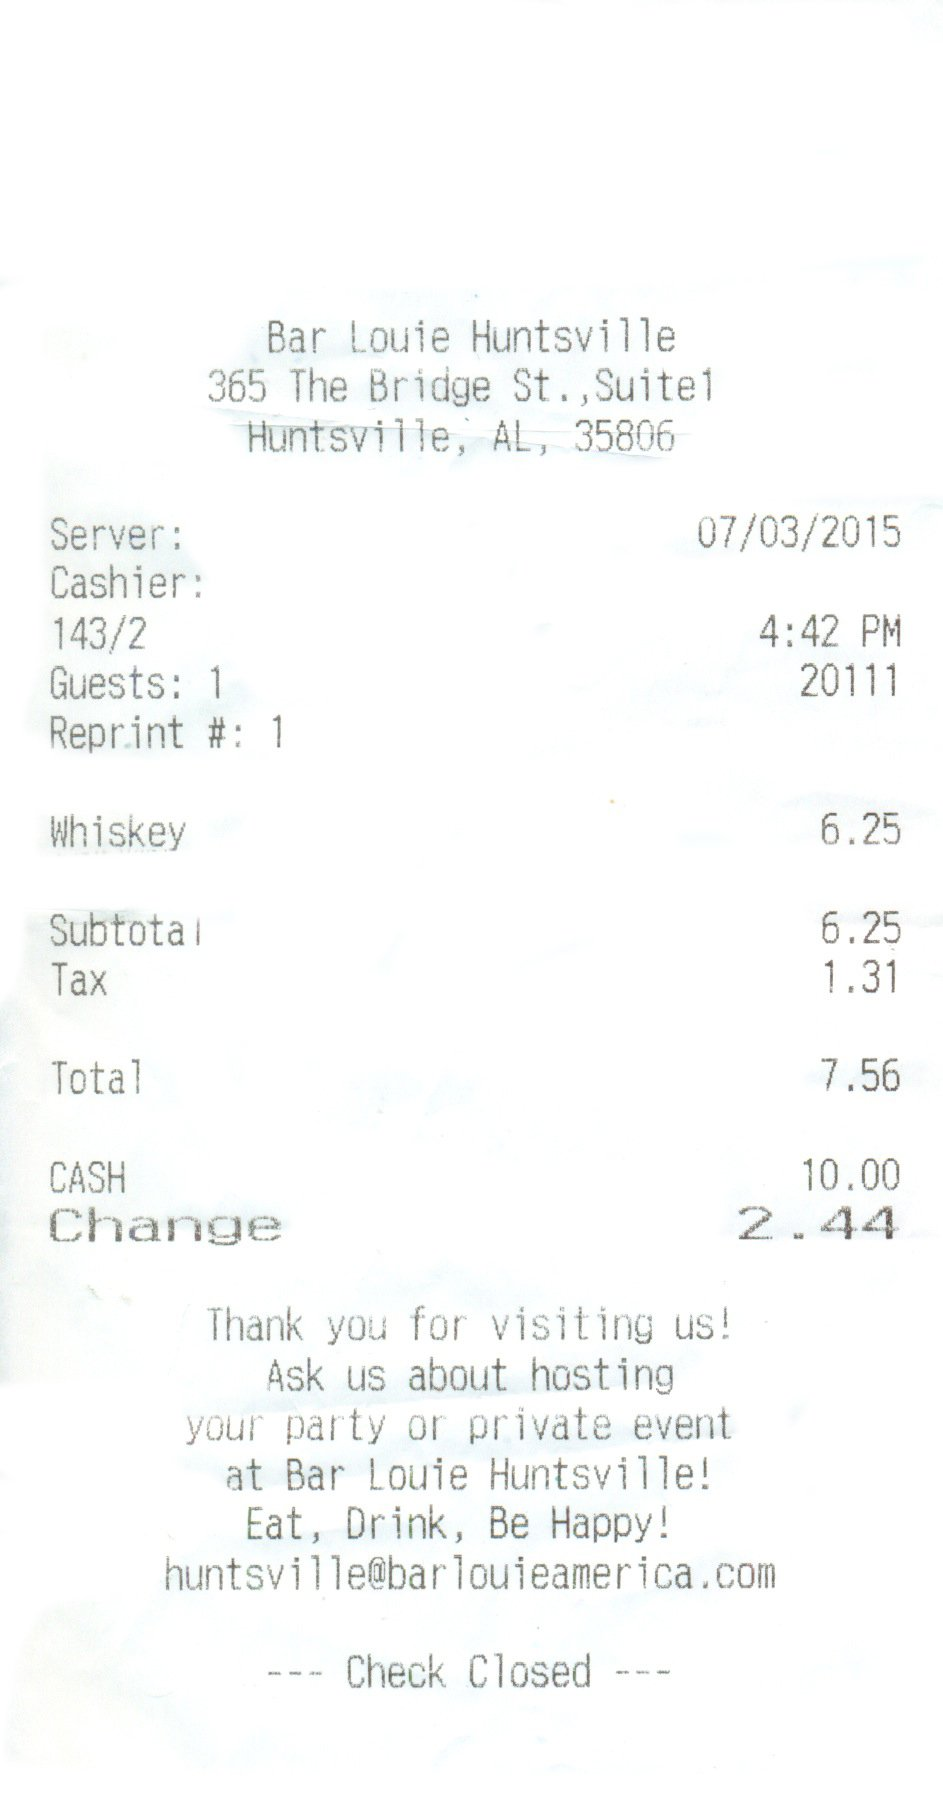

In [305]:
im5

In [293]:
gray = cv2.cvtColor(np.array(im5), cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

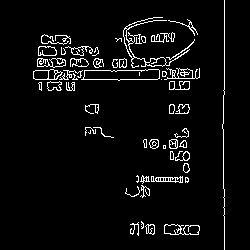

In [294]:
display(Image.fromarray(edged.astype('uint8')))

In [295]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [296]:
cnt = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)

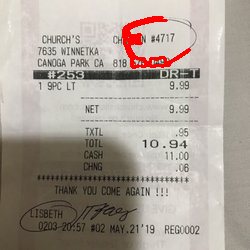

In [297]:
Image.fromarray(cv2.drawContours(np.array(im5), cnt, 0, (255, 0, 0), 2).astype('uint8'))

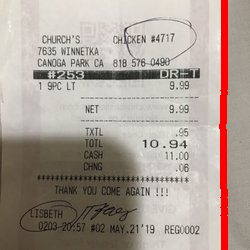

In [298]:
Image.fromarray(cv2.drawContours(np.array(im5), cnt, 1, (255, 0, 0), 5).astype('uint8'))

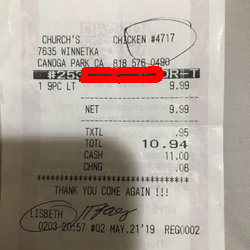

In [299]:
Image.fromarray(cv2.drawContours(np.array(im5), cnt, 2, (255, 0, 0), 5).astype('uint8'))

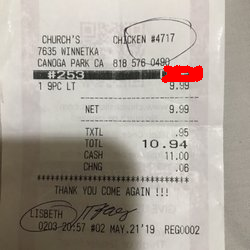

In [300]:
Image.fromarray(cv2.drawContours(np.array(im5), cnt, 3, (255, 0, 0), 5).astype('uint8'))

[05/11/23 15:50:42] WARNING  /tmp/ipykernel_8892/3438911370.py:4: DeprecationWarning: `np.int0` is  ]8;id=332644;file:///home/zig/.pyenv/versions/3.10.8/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=76354;file:///home/zig/.pyenv/versions/3.10.8/lib/python3.10/warnings.py#109\109]8;;\
                             a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)                            
                               box = np.int0(rect)                                                                 
                                                                                                                   

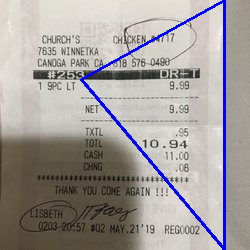

In [301]:
rect = cv2.convexHull(np.concatenate([cnt[0], cnt[1], cnt[2], cnt[3]], axis=0))
# box = cv2.boxPoints(rect)
# box = np.int0(box)
box = np.int0(rect)
esp = box
epsilon = 0.1 * cv2.arcLength(esp,True)
approx = cv2.approxPolyDP(esp,epsilon,True)
Image.fromarray(cv2.drawContours(np.array(im5), [approx], 0, (0,0,255), 2).astype('uint8'))